For the project, I chose a dataset with information about road traffic. These data have been collected over several years and exhibit a seasonal pattern that can manifest at different time intervals. For example, traffic is typically higher after work and in the morning than in the middle of the night. During holiday periods or in the summer, when people travel, traffic can also increase. The dataset can be found here - https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset/data

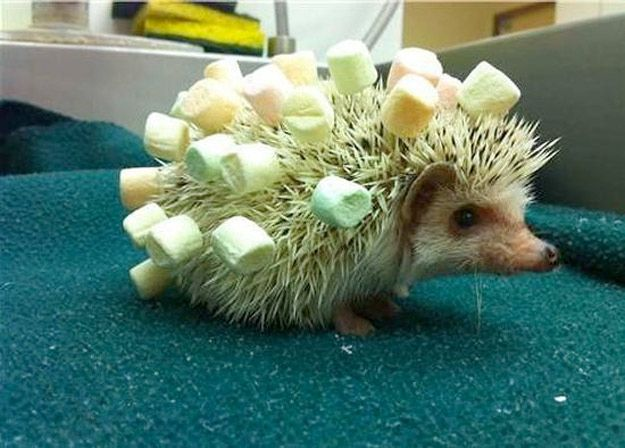

In [1]:
from PIL import Image
from io import BytesIO
import requests
url = "https://i.pinimg.com/736x/0e/31/60/0e3160465e94dbf0e0e3f86485a6961f.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

# Library installation and data loading

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s eta 0:00:00


In [3]:
!pip install prophet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error

In [5]:
url = 'https://raw.githubusercontent.com/DSE-24-25/project-ElizavetaShvachko/main/traffic.csv?raw=True'
df = pd.read_csv(url)


In [6]:
df

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


# EDA and Data Preprocessing

In [7]:
print("Number of missing values:\n", df.isna().sum())
print("\n Data types of columns:\n", df.dtypes)
print("\n Proportion of unique values:\n", df.nunique() / df.shape[0])

Number of missing values:
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

 Data types of columns:
 DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object

 Proportion of unique values:
 DateTime    0.303242
Junction    0.000083
Vehicles    0.002930
ID          1.000000
dtype: float64


The ID variable does not provide any useful information, as it consists only of unique values. It can be excluded from consideration.

In [8]:
df.drop('ID', axis=1, inplace=True)
list_cols = df.columns.to_list()

In [9]:
# The following features are created: day of the week, month number, year, and hour based on the DateTime value.
cat_type = CategoricalDtype(categories=['Monday','Tuesday','Wednesday',
                                        'Thursday','Friday','Saturday','Sunday'],
                            ordered=True)


def create_new_features(df, label=None):
    df = df.copy()
    df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
    df['hour'] = df['DateTime'].dt.hour
    df['weekday'] = df['DateTime'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['month'] = df['DateTime'].dt.month
    df['year'] = df['DateTime'].dt.year
    return df
df = create_new_features(df)
df.head()

,DateTime,Junction,Vehicles,hour,weekday,month,year
0,2015-11-01 00:00:00,1,15,0,Sunday,11,2015
1,2015-11-01 01:00:00,1,13,1,Sunday,11,2015
2,2015-11-01 02:00:00,1,10,2,Sunday,11,2015
3,2015-11-01 03:00:00,1,7,3,Sunday,11,2015
4,2015-11-01 04:00:00,1,9,4,Sunday,11,2015


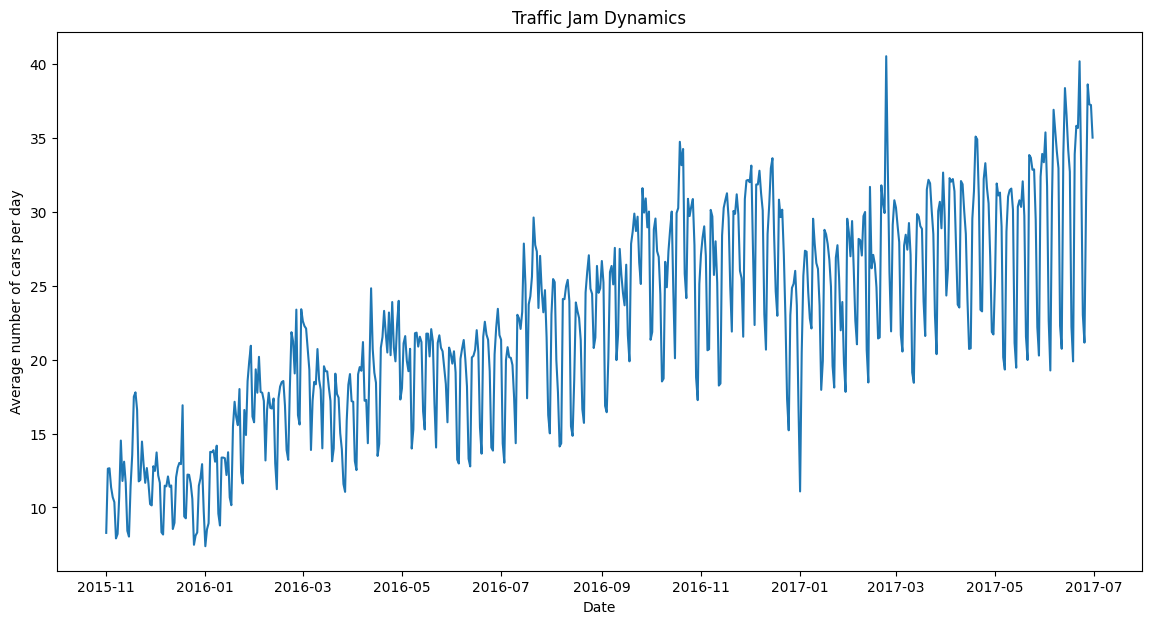

In [10]:
# Grouping by day is necessary because the DateTime variable is not unique in the dataset due to different intersections
df_resampled = df[list_cols].set_index('DateTime').resample('D').mean()
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_resampled, x=df_resampled.index, y='Vehicles')
plt.title('Traffic Jam Dynamics')
plt.xlabel('Date')
plt.ylabel('Average number of cars per day')
plt.show()

<ipython-input-11-9a7931fbde5d>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_traffic = df.groupby('weekday', as_index=False)['Vehicles'].mean()


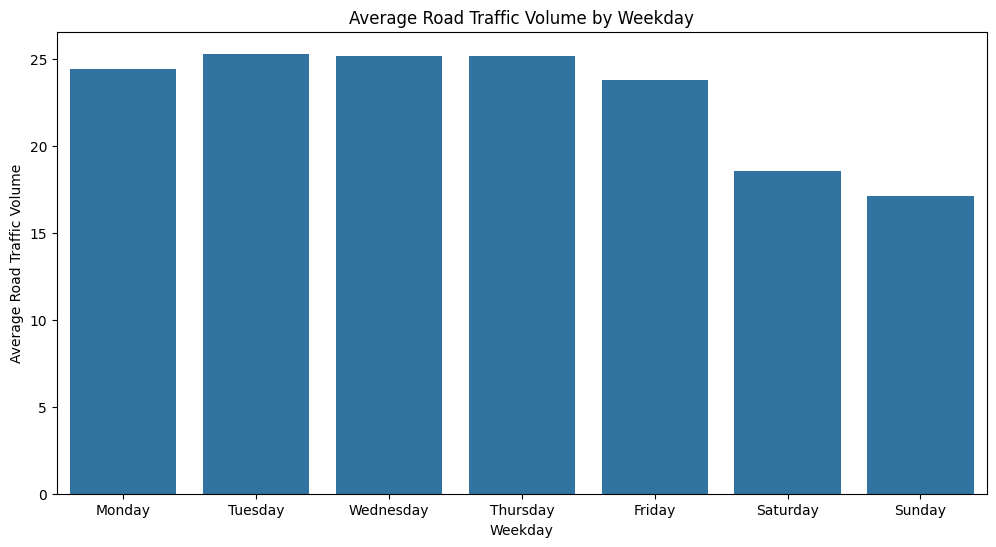

In [11]:
weekly_traffic = df.groupby('weekday', as_index=False)['Vehicles'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x='weekday', y='Vehicles', data=weekly_traffic)
plt.title('Average Road Traffic Volume by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Road Traffic Volume')
plt.show()


It is noticeable that traffic volumes are lower on weekends compared to weekdays

In [12]:
weekly_traffic

,weekday,Vehicles
0,Monday,24.409408
1,Tuesday,25.286731
2,Wednesday,25.149681
3,Thursday,25.152875
4,Friday,23.802120
5,Saturday,18.544611
6,Sunday,17.134727


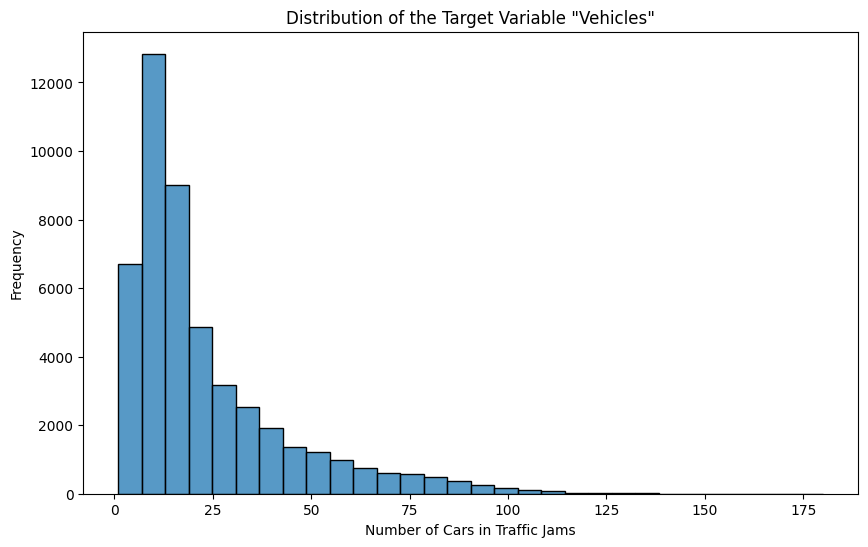

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Vehicles'], kde=False, bins=30)
plt.title('Distribution of the Target Variable "Vehicles"')
plt.xlabel('Number of Cars in Traffic Jams')
plt.ylabel('Frequency')
plt.show()


The variable is distributed with a right-skewed asymmetry

The variable "junction" represents the intersection number from which the data was collected. The intersections are independent of each other.

In [14]:
unique_junctions = df['Junction'].unique()
unique_junctions


array([1, 2, 3, 4])

<ipython-input-15-dea3c4cdc647>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_junctions))



Analysis for Junction 1


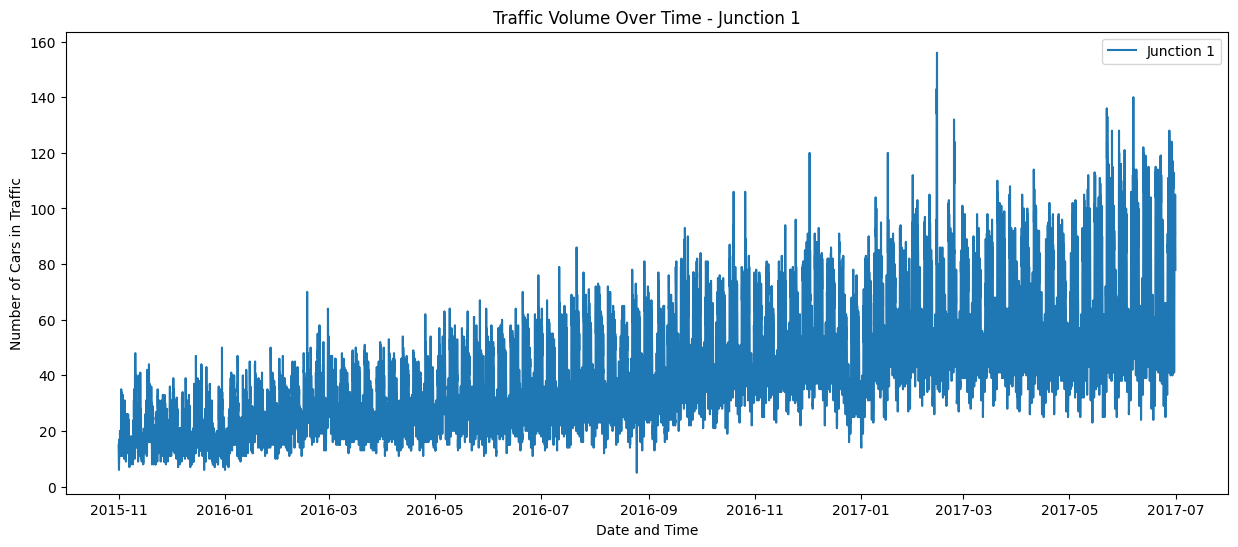

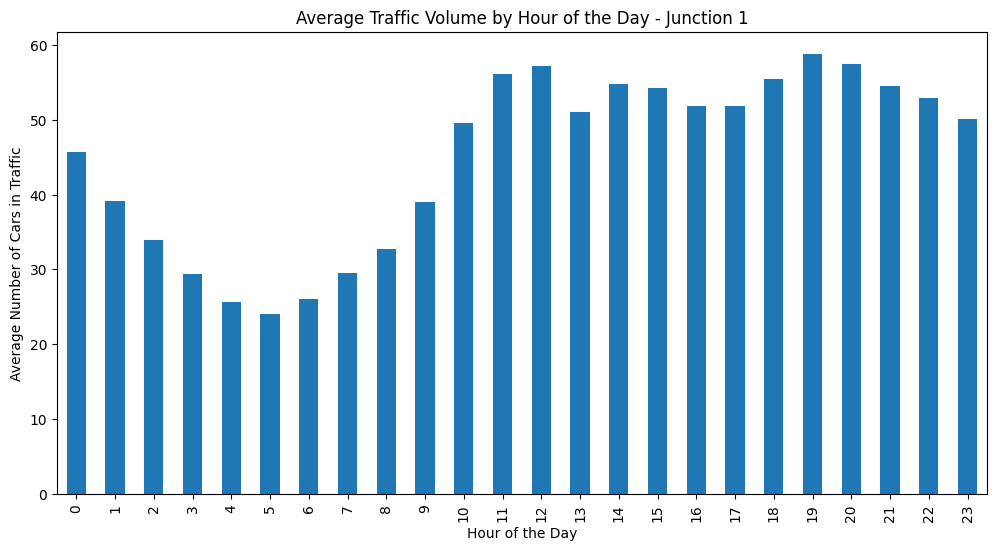

<ipython-input-15-dea3c4cdc647>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_junction.groupby('weekday')['Vehicles'].mean().plot(kind='bar', color=colors(idx))


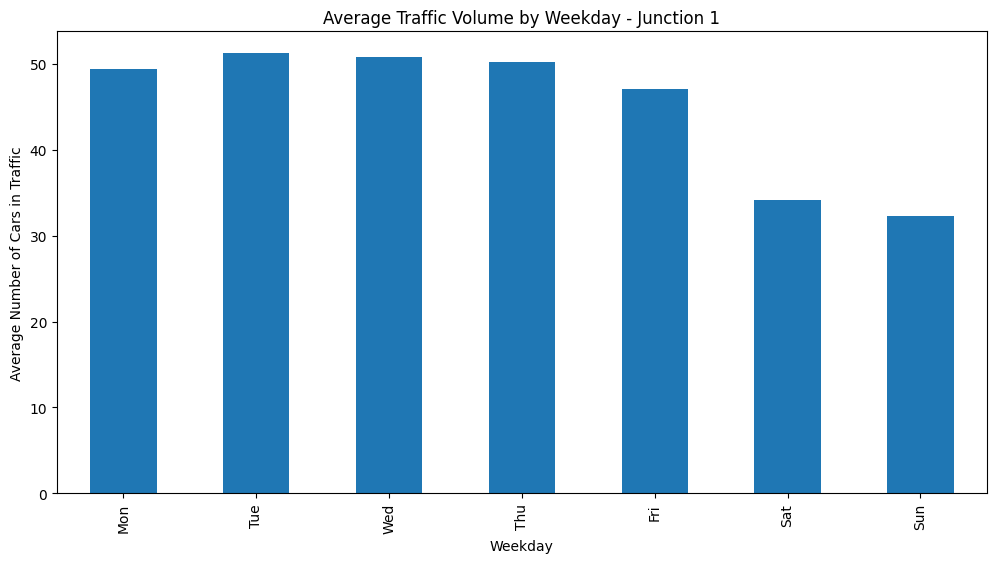


Analysis for Junction 2


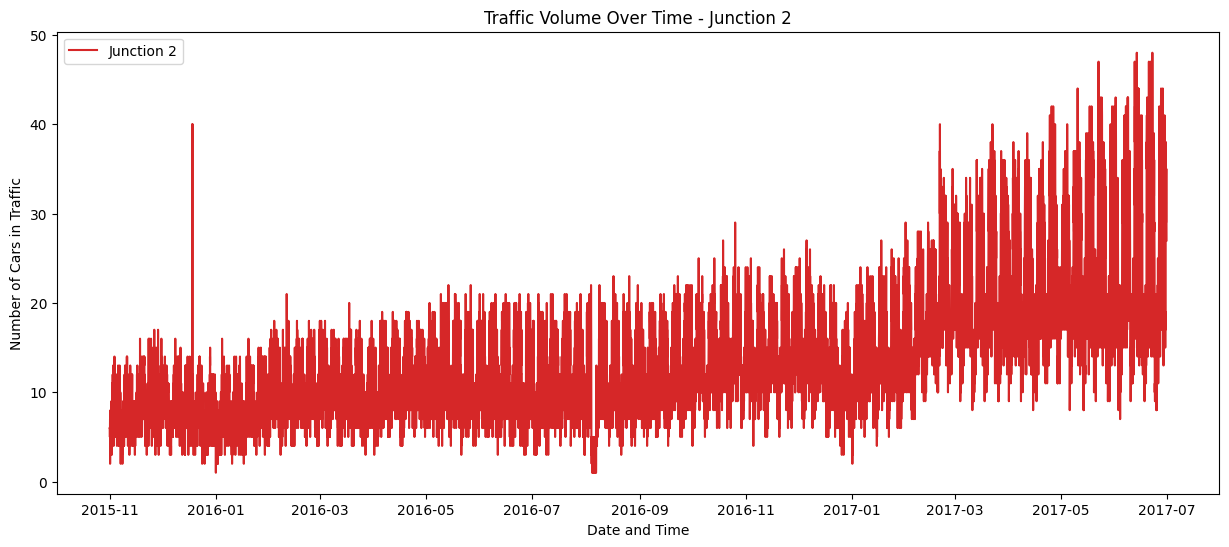

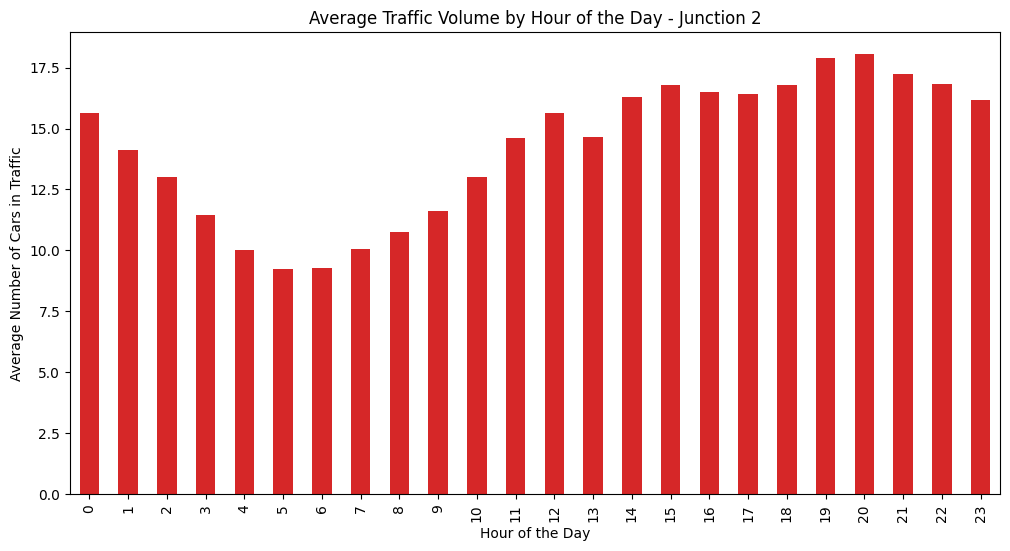

<ipython-input-15-dea3c4cdc647>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_junction.groupby('weekday')['Vehicles'].mean().plot(kind='bar', color=colors(idx))


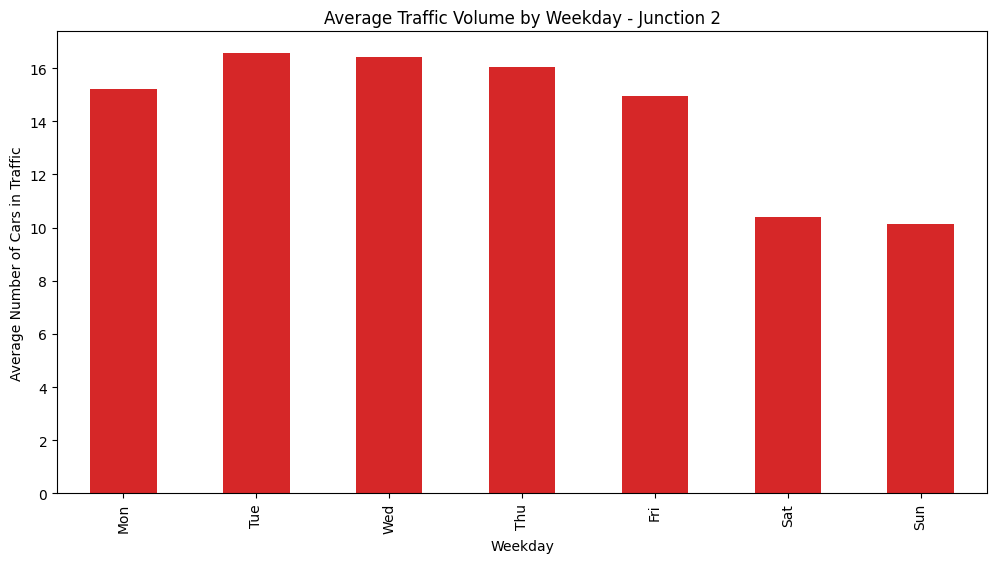


Analysis for Junction 3


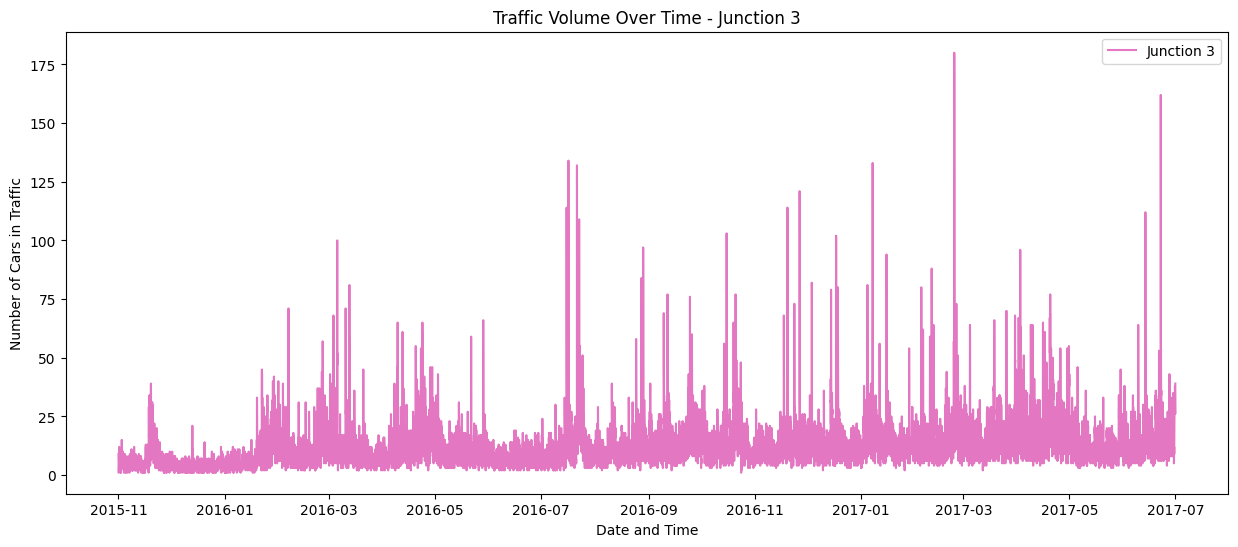

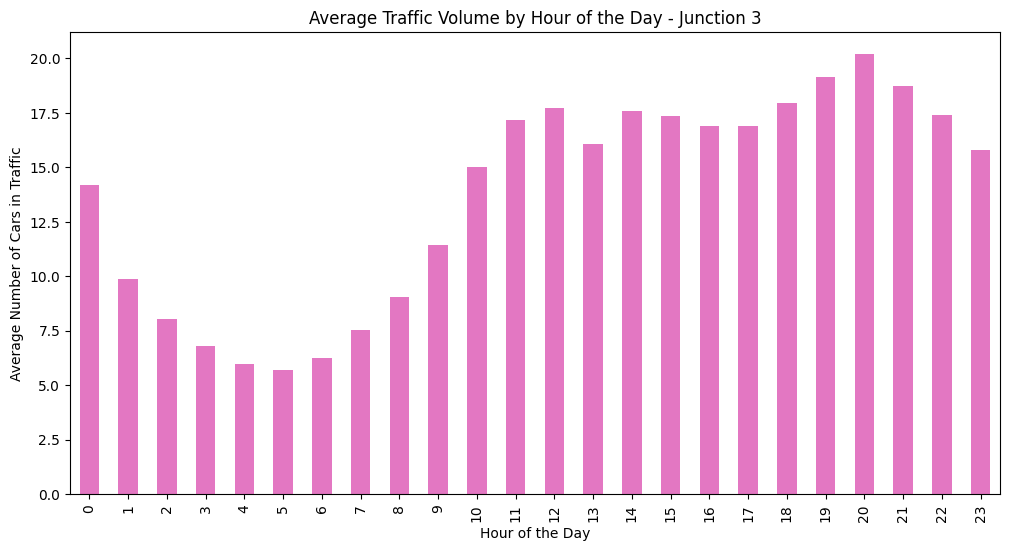

<ipython-input-15-dea3c4cdc647>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_junction.groupby('weekday')['Vehicles'].mean().plot(kind='bar', color=colors(idx))


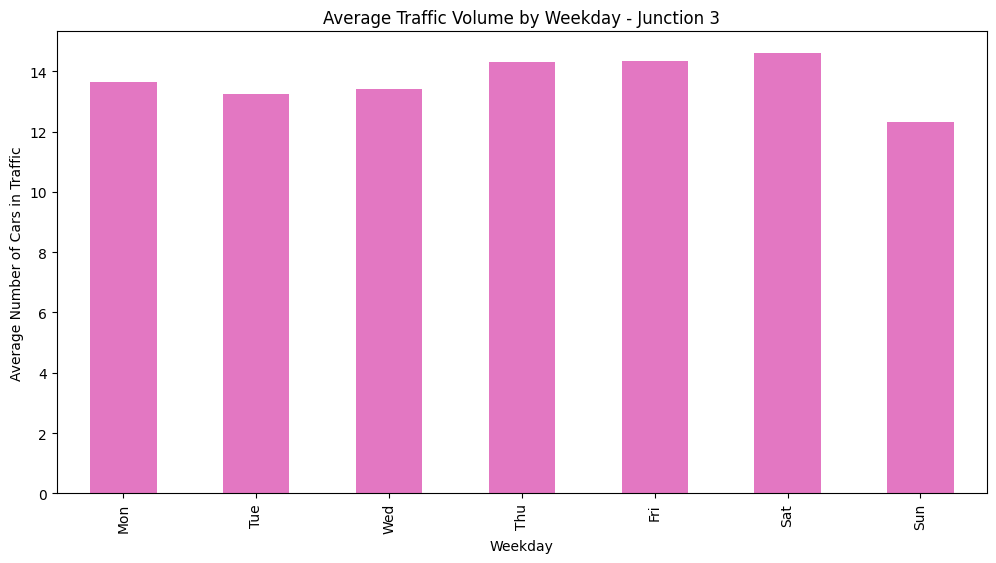


Analysis for Junction 4


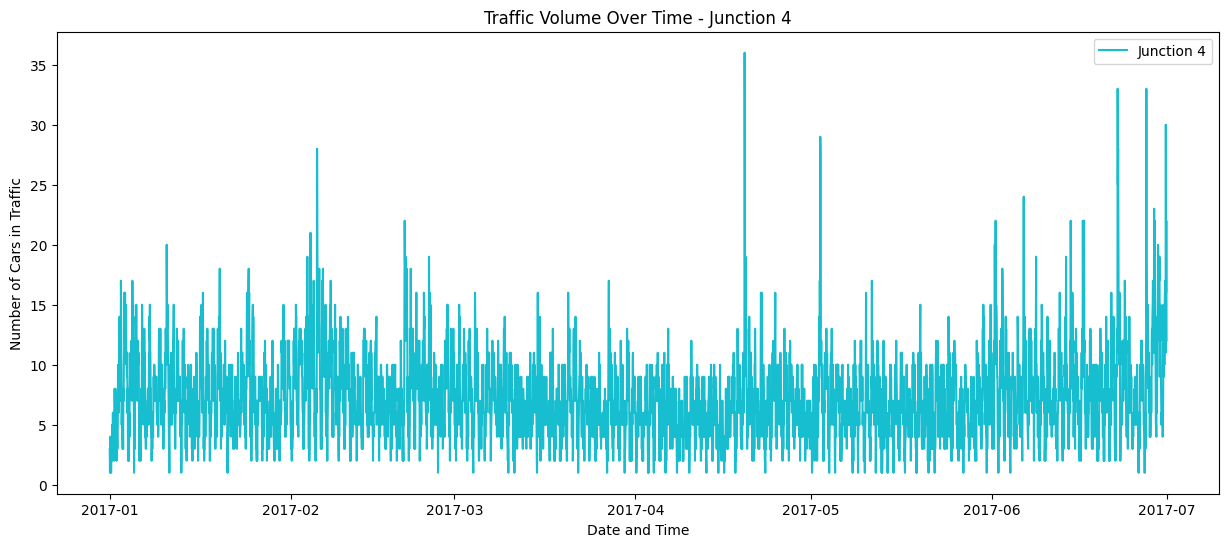

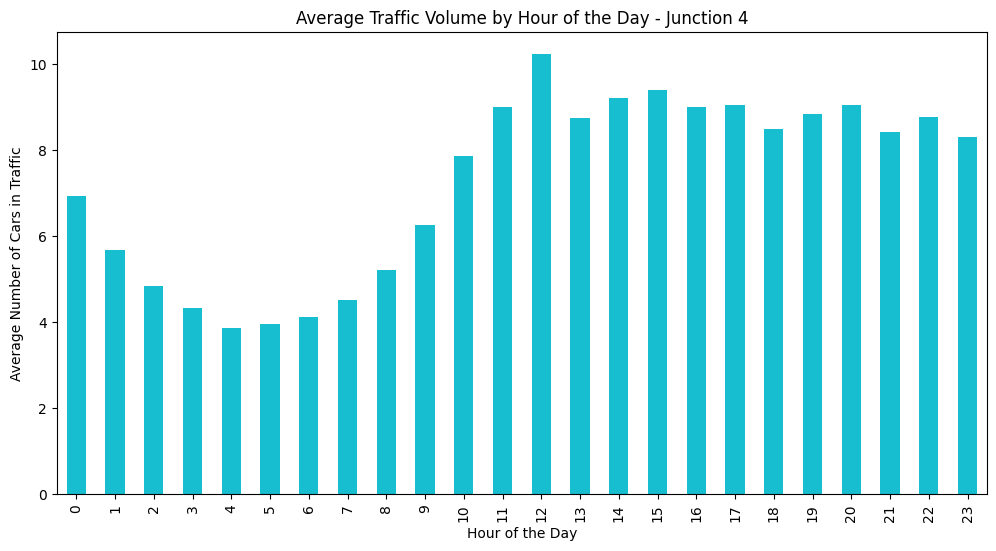

<ipython-input-15-dea3c4cdc647>:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_junction.groupby('weekday')['Vehicles'].mean().plot(kind='bar', color=colors(idx))


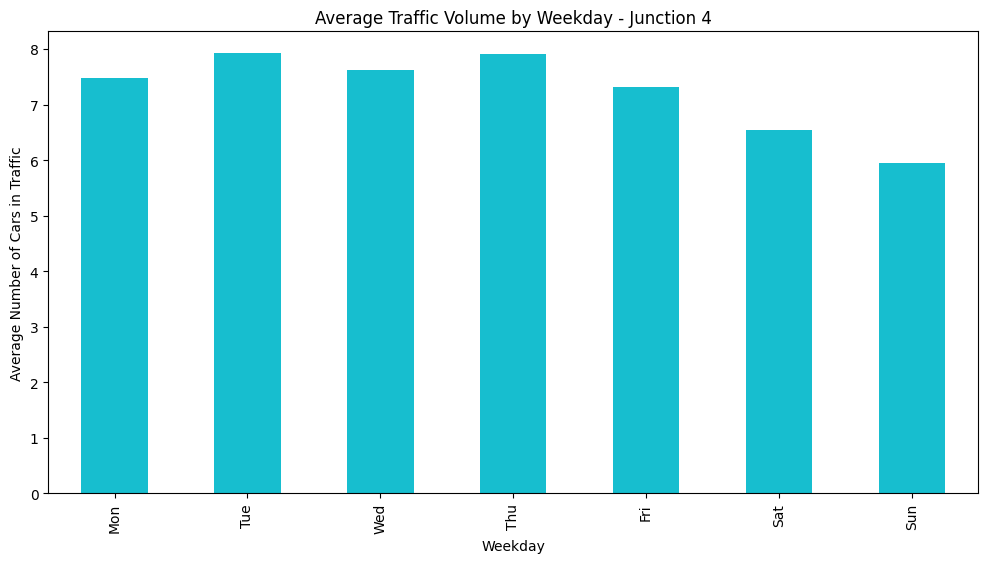

In [15]:
unique_junctions = df['Junction'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_junctions))

for idx, junction in enumerate(unique_junctions):
    print(f"\nAnalysis for Junction {junction}")
    df_junction = df[df['Junction'] == junction]

    # Traffic volume over time for the specific junction
    plt.figure(figsize=(15, 6))
    plt.plot(df_junction['DateTime'], df_junction["Vehicles"], label=f'Junction {junction}', color=colors(idx))
    plt.title(f'Traffic Volume Over Time - Junction {junction}')
    plt.xlabel('Date and Time')
    plt.ylabel('Number of Cars in Traffic')
    plt.legend()
    plt.show()

    # Average traffic volume by hour for the specific junction
    plt.figure(figsize=(12, 6))
    df_junction.groupby('hour')['Vehicles'].mean().plot(kind='bar', color=colors(idx))
    plt.title(f'Average Traffic Volume by Hour of the Day - Junction {junction}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Number of Cars in Traffic')
    plt.show()

    # Average traffic volume by weekday for the specific junction
    plt.figure(figsize=(12, 6))
    df_junction.groupby('weekday')['Vehicles'].mean().plot(kind='bar', color=colors(idx))
    plt.title(f'Average Traffic Volume by Weekday - Junction {junction}')
    plt.xlabel('Weekday')
    plt.ylabel('Average Number of Cars in Traffic')
    plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.show()


Despite the fact that the intersections are different, some common conclusions can still be made from the data. For example, from midnight to 5 AM, a decrease in road activity is observed.

# Time series decomposition into three components

For decomposition, I will use the additive model.
In additive decomposition, the time series is expressed as the sum of its components: Y(t)=Trend(t)+Seasonality(t)+Residual(t).

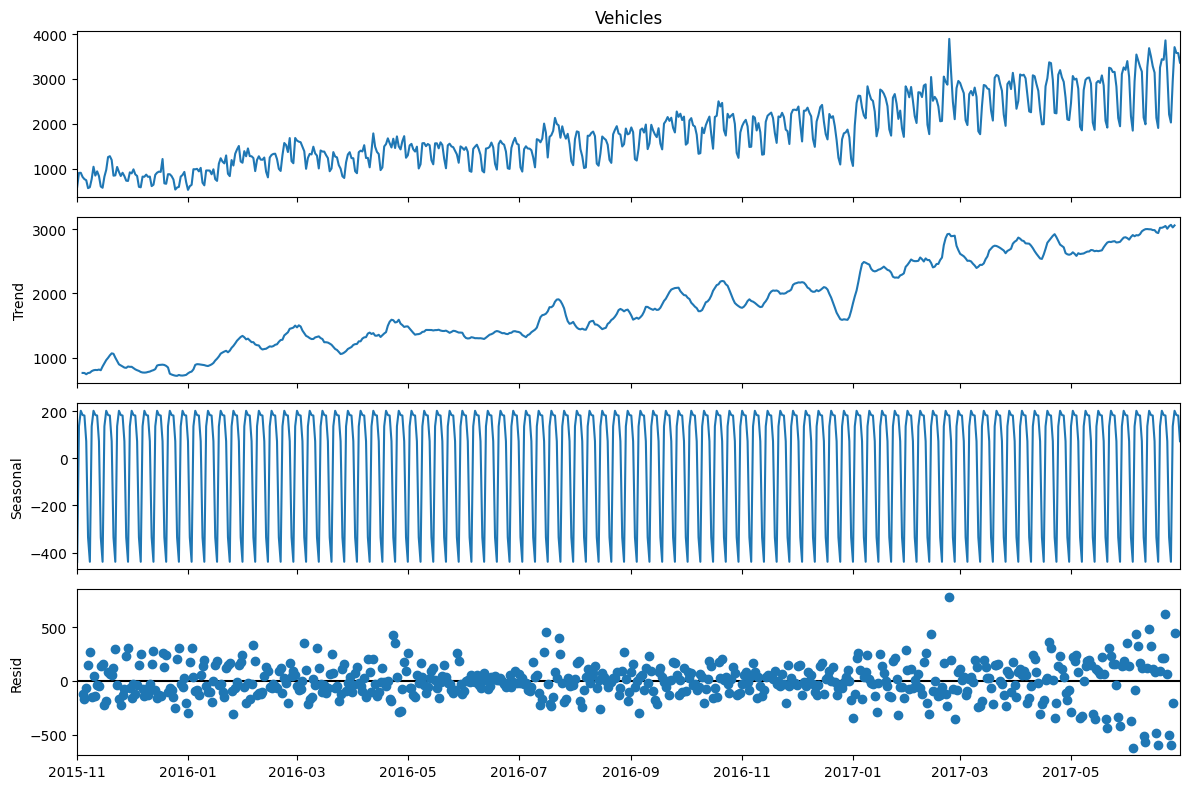

In [17]:
data = pd.read_csv(url)
data['DateTime'] = pd.to_datetime(data['DateTime'])
daily_traffic = data.set_index('DateTime').resample('D').sum()

# The seasonality period is 7 days.
result = seasonal_decompose(daily_traffic['Vehicles'], model='additive', period=7)


plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.tight_layout()
plt.show()


Trend: This component shows a smoothed version of the observed data, reflecting the direction and rate of change in the data distribution. The trend line indicates a gradual increase in the number of cars stuck in traffic. Some fluctuations are also observed, which may correspond to key factors affecting traffic volume over shorter periods.

Seasonality: The seasonal component reflects a regular pattern in the data that repeats over a specific period,
which in this case is considered to be weekly, as the decomposition was performed with a 7-day period. The pattern is very consistent, showing peaks and troughs at regular intervals.

Residuals: These are the irregularities or noise remaining after the trend and seasonal components have been removed from the observed data. Based on the graph, the residuals are randomly scattered around zero with no apparent pattern.

# Training a gradient boosting model

In [18]:
# Create features: season, day of the month
def create_dop_features(df):
    data = df.copy()
    data["season"] = data["month"].apply(lambda x: "Winter" if x in [12, 1, 2] else
                                           "Spring" if x in [3, 4, 5] else
                                           "Summer" if x in [6, 7, 8] else "Autumn")
    for lag in [1, 2, 3, 6]:
      data[f"Lag_{lag}"] = data["Vehicles"].shift(lag)
    data['day'] = data['DateTime'].dt.day

    return data

df = create_dop_features(df)
df.head()


,DateTime,Junction,Vehicles,hour,weekday,month,year,season,Lag_1,Lag_2,Lag_3,Lag_6,day
0,2015-11-01 00:00:00,1,15,0,Sunday,11,2015,Autumn,NaN,NaN,NaN,NaN,1
1,2015-11-01 01:00:00,1,13,1,Sunday,11,2015,Autumn,15.0,NaN,NaN,NaN,1
2,2015-11-01 02:00:00,1,10,2,Sunday,11,2015,Autumn,13.0,15.0,NaN,NaN,1
3,2015-11-01 03:00:00,1,7,3,Sunday,11,2015,Autumn,10.0,13.0,15.0,NaN,1
4,2015-11-01 04:00:00,1,9,4,Sunday,11,2015,Autumn,7.0,10.0,13.0,NaN,1


In [19]:
df[df['DateTime'] == '2017-03-01 09:00:00']

,DateTime,Junction,Vehicles,hour,weekday,month,year,season,Lag_1,Lag_2,Lag_3,Lag_6,day
11673,2017-03-01 09:00:00,1,60,9,Wednesday,3,2017,Spring,50.0,43.0,43.0,50.0,1
26265,2017-03-01 09:00:00,2,26,9,Wednesday,3,2017,Spring,17.0,17.0,18.0,22.0,1
40857,2017-03-01 09:00:00,3,17,9,Wednesday,3,2017,Spring,12.0,6.0,9.0,6.0,1
45201,2017-03-01 09:00:00,4,8,9,Wednesday,3,2017,Spring,6.0,2.0,5.0,5.0,1


Since the dataset contains traffic data for each hour at four different intersections, it is necessary to aggregate the data so that the model predicts the total traffic load on the intersections. Without this, the ETS model will not make accurate predictions, as the DateTime variable needs to be unique.

In [20]:
aggregated_data = df.groupby('DateTime').agg(
    Total_Vehicles=('Vehicles', 'sum'),
    hour=('hour', 'first'),
    weekday=('weekday', 'first'),
    month=('month', 'first'),
    year=('year', 'first'),
    season=('season', 'first'),
    day=('day', 'first')
).reset_index()



# сreating 4 new variables.
# Junction_1_Share represents the share of vehicles at the first intersection relative to the total traffic load at all intersections at that moment
# Junction_2_Share, Junction_3_Share, Junction_4_Share represent the same, but for the second, third, and fourth intersections, respectively.
junction_shares = df.pivot_table(
    index='DateTime',
    columns='Junction',
    values='Vehicles',
    aggfunc='sum'
)
junction_shares = junction_shares.div(junction_shares.sum(axis=1), axis=0)
junction_shares.columns = [f'Junction_{col}_Share' for col in junction_shares.columns]


final_data = aggregated_data.merge(junction_shares, on='DateTime', how='left')

for lag in [1, 2, 3, 6]:
    final_data[f'Total_Vehicles_Lag_{lag}'] = final_data['Total_Vehicles'].shift(lag)

In [21]:
# the feature Total_Vehicles_Lag_6 represents the total traffic load across all intersections six hours ago, and the other features are calculated similarly.
final_data[final_data['DateTime'] == '2017-03-01 09:00:00']

,DateTime,Total_Vehicles,hour,weekday,month,year,season,day,Junction_1_Share,Junction_2_Share,Junction_3_Share,Junction_4_Share,Total_Vehicles_Lag_1,Total_Vehicles_Lag_2,Total_Vehicles_Lag_3,Total_Vehicles_Lag_6
11673,2017-03-01 09:00:00,111,9,Wednesday,3,2017,Spring,1,0.540541,0.234234,0.153153,0.072072,85.0,68.0,75.0,83.0


In [22]:
# select only the numerical columns.
numeric_c = final_data.select_dtypes(include=['number'])
final_data[numeric_c.columns] = numeric_c.fillna(0)

In [23]:
# splitting the data into train and test sets with 80% for training and 20% for testing:
final_data.sort_values(by='DateTime', inplace=True)
train = final_data[0:int(len(final_data)*0.8)]
test= final_data[int(len(final_data)*0.8):]


 Number of records in the training set

11673

 Start and end of the training set by DateTime

2015-11-01 00:00:00 - 2017-03-01 08:00:00

 Number of records in the test set

2919

 Start and end of the test set by DateTime

2017-03-01 09:00:00 - 2017-06-30 23:00:00


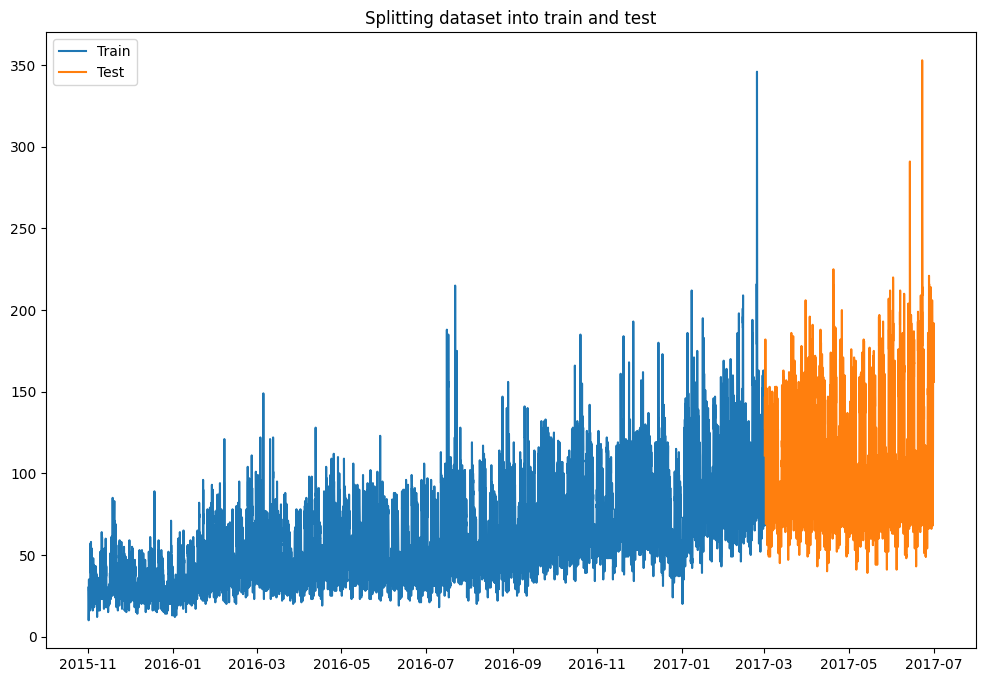

In [24]:
print("\n Number of records in the training set\n")
print(len(train))
print("\n Start and end of the training set by DateTime\n")
print(train.DateTime.min(), '-', train.DateTime.max())

print("\n Number of records in the test set\n")
print(len(test))
print("\n Start and end of the test set by DateTime\n")
print(test.DateTime.min(), '-', test.DateTime.max())

plt.plot(train.DateTime, train.Total_Vehicles, label = 'Train')
plt.plot(test.DateTime, test.Total_Vehicles, label = 'Test')
plt.legend(loc = 'best')
plt.title('Splitting dataset into train and test')
plt.show()


In [25]:
y_train = train["Total_Vehicles"]
X_train = train.drop(columns="Total_Vehicles")

y_test = test["Total_Vehicles"]
X_test = test.drop(columns="Total_Vehicles")

For gradient boosting, the CatBoost implementation is chosen, which supports categorical variables

In [26]:
cat_features = ["weekday", "year", "season"]
model = CatBoostRegressor(cat_features=cat_features, verbose=0, random_state=42)
model.fit(X_train, y_train)
predictions_boosting = model.predict(X_test)

rmse_boost = np.sqrt(mean_squared_error(y_test, predictions_boosting))
mape_boost = np.mean(np.abs((y_test - predictions_boosting) / y_test)) * 100

# Training an ETS model


The model implements the exponential smoothing method, which is used for making forecasts. An additive approach is used, where the seasonal effect is added to other components, such as the trend.

In [27]:
ets_model = ExponentialSmoothing(train['Total_Vehicles'], seasonal='additive', seasonal_periods=24, trend='additive', damped_trend=True)
ets_fit = ets_model.fit()

predictions_ets = ets_fit.forecast(steps=len(test))

rmse_ets = np.sqrt(mean_squared_error(test['Total_Vehicles'], predictions_ets))
mape_ets = np.mean(np.abs((test['Total_Vehicles'] - predictions_ets) / test['Total_Vehicles'])) * 100


# Training Prophet

A library from Facebook for time series forecasting

In [28]:
from prophet import Prophet
prophet_data = train.select_dtypes(include=['number', 'datetime']).rename(columns={'DateTime': 'ds', 'Total_Vehicles': 'y'})


model = Prophet(
    seasonality_mode='additive',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.1
)

# adding additional regressors
model.add_regressor('hour')
model.add_regressor('year')
model.add_regressor('month')
model.add_regressor('day')
model.add_regressor('Junction_1_Share')
model.add_regressor('Junction_2_Share')
model.add_regressor('Junction_3_Share')
model.add_regressor('Junction_4_Share')
model.add_regressor('Total_Vehicles_Lag_1')
model.add_regressor('Total_Vehicles_Lag_2')
model.add_regressor('Total_Vehicles_Lag_3')
model.add_regressor('Total_Vehicles_Lag_6')


model.fit(prophet_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmph1klinvm/xntiei9j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph1klinvm/0usged5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85505', 'data', 'file=/tmp/tmph1klinvm/xntiei9j.json', 'init=/tmp/tmph1klinvm/0usged5t.json', 'output', 'file=/tmp/tmph1klinvm/prophet_modelurtrpltr/prophet_model-20250103194903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:49:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:49:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [29]:
future_df = X_test.select_dtypes(include=['number', 'datetime']).rename(columns={'DateTime': 'ds'})
forecast = model.predict(future_df)

mape_prop = mean_absolute_percentage_error(test['Total_Vehicles'], forecast['yhat'])
rmse_prop = np.sqrt(mean_squared_error(test['Total_Vehicles'], forecast['yhat']))

# Comparison of models on the test set

The metrics chosen for comparing algorithms are:

1. MAPE - shows the percentage error between the forecasts and the actual results. This is a relative metric.
2. RMSE - the root of the squared deviation between the forecasts and the actual values. This is an absolute metric and shows the error in the units of the predicted variable (total number of cars at the 4 intersections).

In [30]:
compare_df = {
    'Model': ['Grad.boosting', 'ETS', 'Prophet'],
    'MAPE': [mape_boost, mape_ets, mape_prop],
    'RMSE': [rmse_boost, rmse_ets, rmse_prop],
}

compare_df = pd.DataFrame(compare_df)
compare_df

,Model,MAPE,RMSE
0,Grad.boosting,6.094608,10.219838
1,ETS,18.816291,29.052602
2,Prophet,0.074580,12.868258


Among all three algorithms, ETS has the worst quality metrics. This is due to its inability to incorporate information from additional variables. Gradient boosting has a small percentage error, and overall, the predictions are quite close to the true values, despite some outliers in the data. Prophet predicts most values significantly more accurately, but appears to make large errors a few times, as indicated by its higher RMSE compared to boosting


To better visualize the analysis, it's better to look at the forecasts in the time series.

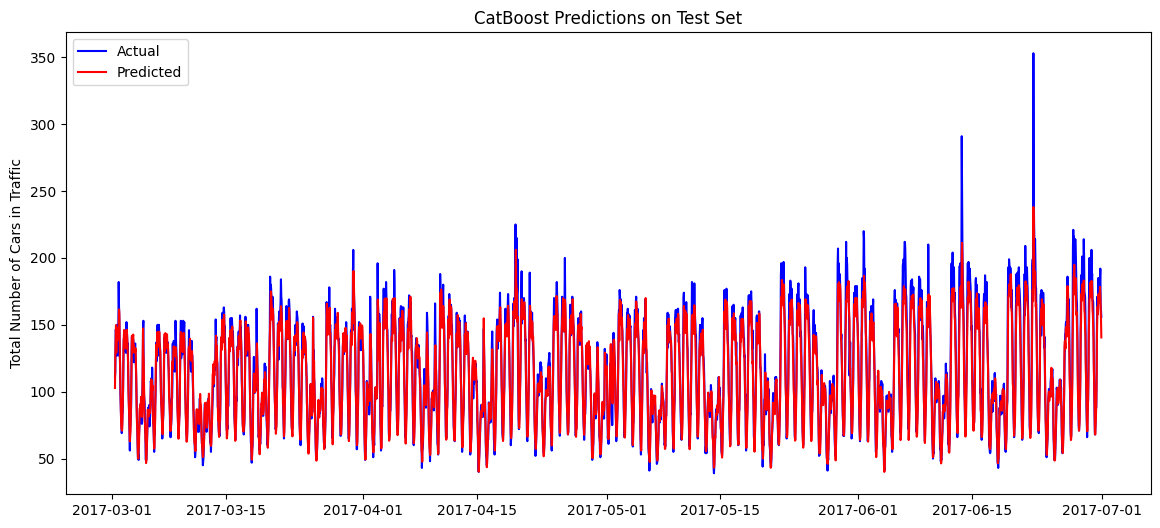

In [31]:
plt.figure(figsize=(14, 6))
plt.plot(test.DateTime, y_test, label="Actual", color="blue")
plt.plot(test.DateTime, predictions_boosting, label="Predicted", color="red")
plt.title("CatBoost Predictions on Test Set")
plt.ylabel("Total Number of Cars in Traffic")
plt.legend()
plt.show()


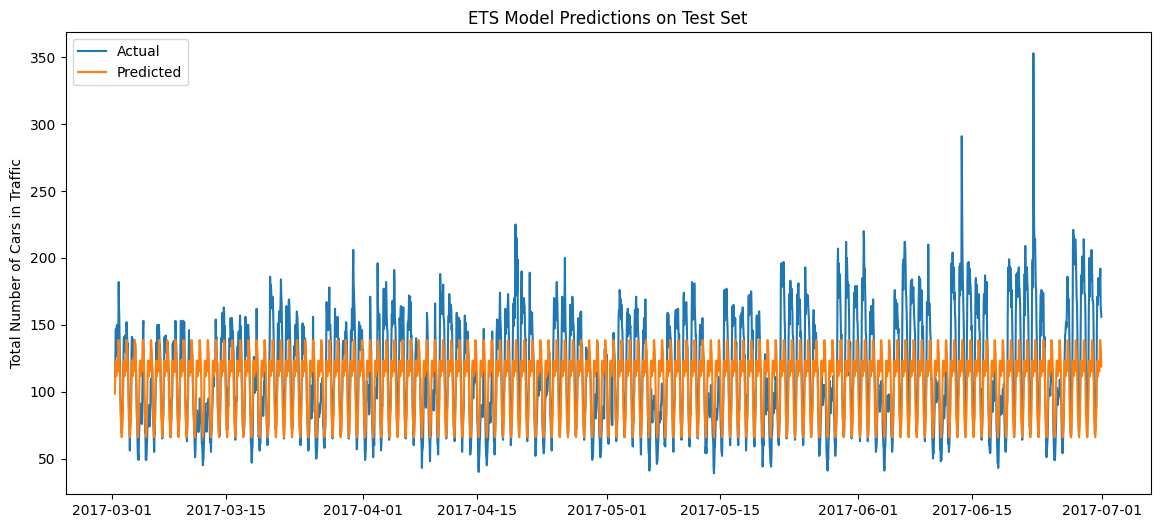

In [32]:
plt.figure(figsize=(14,6))
plt.plot(test['DateTime'], y_test, label='Actual')
plt.plot(test['DateTime'], predictions_ets, label='Predicted')
plt.title('ETS Model Predictions on Test Set')
plt.legend(loc='best')
plt.ylabel('Total Number of Cars in Traffic')
plt.show()


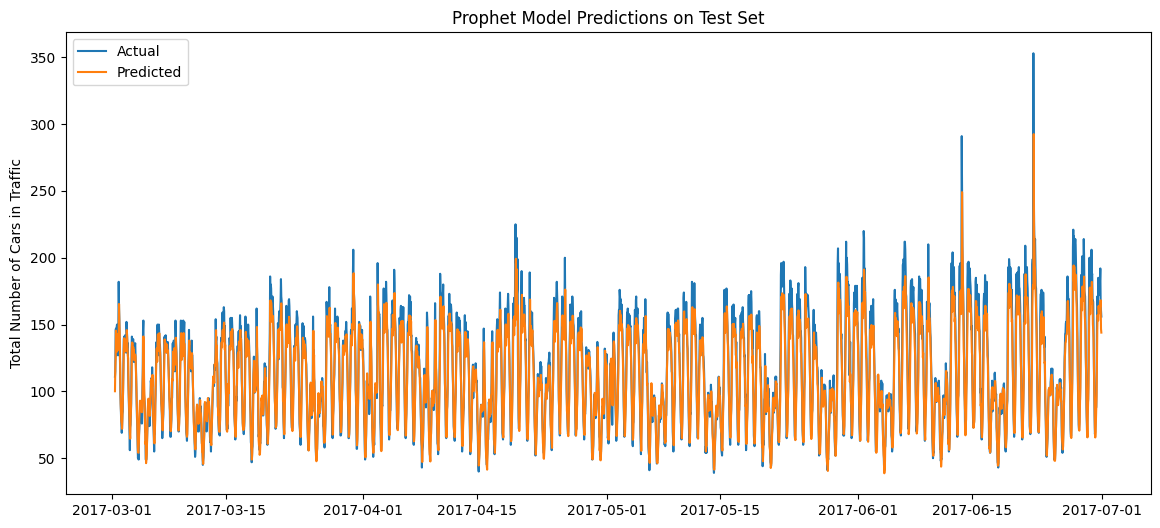

In [33]:
plt.figure(figsize=(14,6))
plt.plot(test['DateTime'], y_test, label='Actual')
plt.plot(test['DateTime'], forecast['yhat'], label='Predicted')
plt.title('Prophet Model Predictions on Test Set')
plt.legend(loc='best')
plt.ylabel('Total Number of Cars in Traffic')
plt.show()


The difference in MAPE between gradient boosting and Prophet is much larger than the difference in RMSE between these models. Therefore, Prophet performs better than all other algorithms in this task

Thank you for the interesting project!

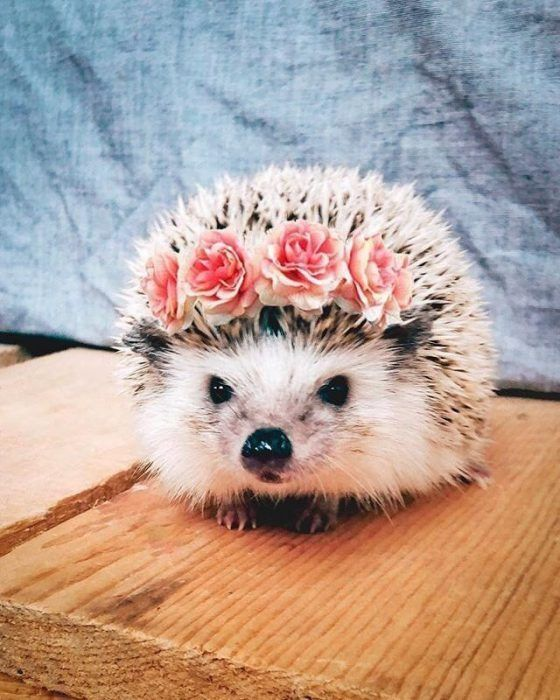

In [34]:
url = "https://i.pinimg.com/736x/f9/3d/af/f93daf43f9fc5e5c477ac3353946016e.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img